In [14]:
from fastai.vision import *
from fastai.vision.all import *
import torch
import torchvision
import torch.nn as nn
from loss_functions.triplet_loss import TripletLoss
from fastai.vision.augment import *
from fastai.vision.learner import cnn_learner
from fastai.vision.models import resnet34
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders

In [15]:
import fastai
fastai.__version__

'2.3.1'

In [16]:
class L2_norm(nn.Module):
    def __init__(self):
        super(L2_norm, self).__init__()

    def forward(self, x):
        return F.normalize(x, p=2, dim=-1)

In [17]:
device = 0
torch.cuda.set_device(device)

In [18]:
batch_size = 128
size = 28

In [19]:
tfms = aug_transforms()

In [20]:
from fastai.basics import *
mnist = untar_data(URLs.MNIST)
tfms = aug_transforms(do_flip=False)

In [21]:
fnames = get_image_files(mnist)
def label_func(x): return x.parent.name
dls = ImageDataLoaders.from_path_func(mnist, fnames, label_func)

In [22]:
# dls.valid_dl.new(shuffle=True)
# Original is a fastai data (valid_dl etc.)

In [23]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, loss_func=TripletLoss(device))

In [24]:
layers = learn.model[1]
learn.model[1] = nn.Sequential(layers[0], layers[1], layers[2], layers[3], nn.Linear(in_features=1024, out_features=128, bias=False), L2_norm()).to(device)
    

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.17378008365631104)

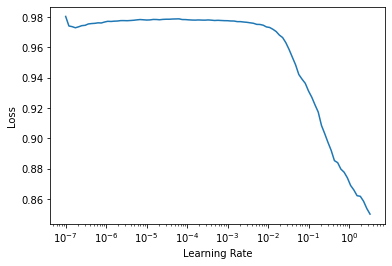

In [28]:
learn.lr_find()

In [29]:
lr = 0.17
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.170137,0.146599,0.013857,00:23
1,0.128304,0.322568,0.000071,00:23
2,0.108183,0.129079,0.000929,00:23
3,0.088700,0.100853,0.000929,00:23
4,0.067011,0.066188,0.000857,00:22
5,0.054311,0.060466,0.002143,00:23
6,0.033569,0.046479,0.001000,00:23
7,0.036592,0.044013,0.001143,00:23
8,0.029922,0.042103,0.001000,00:23
9,0.024668,0.041339,0.000786,00:23


In [30]:
learn.save('10epochs')

Path('/home/larry/.fastai/data/mnist_png/models/10epochs.pth')

In [31]:
learn.load('10epochs')
learn.unfreeze()

SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=6.309573450380412e-07)

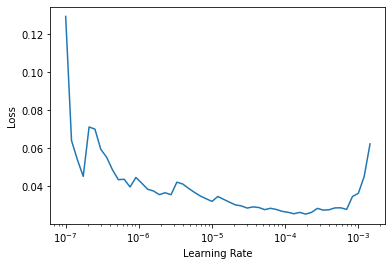

In [32]:
learn.lr_find()

In [35]:
learn.fit_one_cycle(10,slice(.005))

epoch,train_loss,valid_loss,accuracy,time
0,0.077254,0.110890,0.001857,00:27
1,0.098196,0.080000,0.000000,00:27
2,0.064253,0.056351,0.000071,00:27
3,0.046748,0.054430,0.000286,00:27
4,0.050159,0.078227,0.000357,00:27
5,0.026347,0.040078,0.000643,00:28
6,0.018211,0.035787,0.000357,00:29
7,0.011007,0.029542,0.000500,00:30
8,0.008084,0.027850,0.000286,00:27
9,0.005047,0.028251,0.000643,00:27


SuggestedLRs(lr_min=1.1587773087740061e-07, lr_steep=0.1644371747970581)

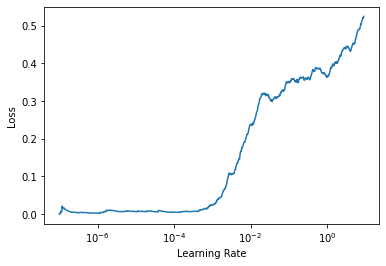

In [39]:
learn.lr_find(num_it=1000, stop_div=False)


In [43]:
learn.fit_one_cycle(30,slice(.01))

epoch,train_loss,valid_loss,accuracy,time
0,0.003197,0.036939,0.000214,00:27
1,0.000677,0.031970,0.000143,00:28
2,0.001598,0.035894,0.000071,00:27
3,0.003827,0.039105,0.000000,00:28
4,0.007179,0.044534,0.000000,00:28
5,0.009197,0.038841,0.000071,00:28
6,0.007772,0.043779,0.000000,00:28
7,0.006542,0.040621,0.000000,00:28
8,0.009611,0.043663,0.000000,00:28
9,0.005907,0.044237,0.000000,00:28


SuggestedLRs(lr_min=0.002754228748381138, lr_steep=6.309573450380412e-07)

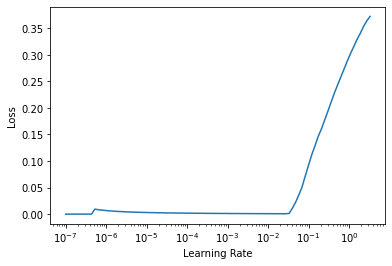

In [44]:
learn.lr_find(stop_div=False)

In [45]:
learn.save('30epochs')

Path('/home/larry/.fastai/data/mnist_png/models/100epochs.pth')

## Now, how to inference? 

Use ~/.fastai/data/mnist_tiny/valid/3/76.png

In [48]:
img = PILImage.create('/home/larry/.fastai/data/mnist_tiny/valid/3/76.png')

In [52]:
result = learn.predict(img)
fingerprint = result[1].numpy()
print(fingerprint)

tensor([ 0.0145, -0.0410, -0.1061, -0.0232, -0.0193,  0.0346, -0.0192, -0.0158,
         0.0558, -0.0842, -0.1286,  0.1808,  0.0649, -0.0318,  0.0814, -0.2131,
        -0.0942, -0.0408,  0.0428, -0.0291, -0.0080,  0.0312,  0.1596, -0.0155,
         0.1033, -0.0222,  0.2176,  0.1117,  0.0189,  0.0710,  0.0922,  0.0178,
        -0.0385, -0.0442,  0.1602,  0.1313, -0.0013,  0.0630,  0.0529, -0.0302,
         0.0251, -0.0483,  0.0561,  0.1632, -0.0309, -0.0422,  0.0744,  0.0551,
         0.0210, -0.0933,  0.0656, -0.1046, -0.0825, -0.0428,  0.1289, -0.0059,
        -0.0227, -0.0582,  0.0605,  0.0317,  0.1307, -0.0952, -0.0324,  0.1670,
        -0.0312,  0.0605, -0.0168, -0.0991,  0.0025, -0.0453,  0.0050,  0.0642,
         0.0413,  0.0881,  0.0100,  0.1729,  0.1161,  0.1297, -0.0392, -0.1157,
         0.0670,  0.0362, -0.0176, -0.0985, -0.2710,  0.1042,  0.0680, -0.1231,
         0.0523, -0.0245, -0.1559, -0.0441,  0.0443, -0.0567, -0.0029,  0.1690,
         0.0271, -0.1567, -0.1183,  0.08

In [50]:
type(fingerprint)

tuple

In [53]:
len(fingerprint)

128

In [55]:
result[-1].detach() == fingerprint

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])

## Train a same/not-same classifier

Based on https://stackoverflow.com/questions/45255030/how-to-determine-accuracy-with-triplet-loss-in-a-convolutional-neural-network

In [59]:
class ClassifierNet(nn.Module):
    def __init__(self, model):
        super(ClassifierNet, self).__init__()
        self.embeddingLayer = model
        self.classifierLayer = nn.Linear(128,62)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.dropout(self.embeddingLayer(x))
        x = self.classifierLayer(x)
        return F.log_softmax(x, dim=1)
    
yesNoNet = ClassifierNet(learn.model)

TODO: Train this on yes / no pairs

## Nearest k-neighbors

based on https://github.com/sanku-lib/image_triplet_loss/blob/master/Prediction.ipynb

In [84]:
fnames = list(Path(mnist/'test').rglob('*.png'))
len(fnames)

10000

In [85]:
fnames[0]

Path('/home/larry/.fastai/data/mnist_png/test/4/8861.png')

In [87]:
def FingerprintAll(fnames):
    fingerprints = {}
    for f in fnames:
        category = label_func(f)
        img = PILImage.create(f)
        result = learn.predict(img)
        fingerprint = result[1].numpy()
        fingerprints[(category,f)] = fingerprint
    return fingerprints

# Takes about 3 minutes -- no big deal
%time fingerprint_db = FingerprintAll(Path(mnist/'test').rglob('*.png'))

CPU times: user 3min 24s, sys: 6.27 s, total: 3min 31s
Wall time: 3min 22s


In [98]:
# Find k nearest neighbour using cosine similarity
def find_k_nn(vectors,vec,k):
    dist_arr = np.matmul(vectors, vec.T)
    return np.argsort(-dist_arr.flatten())[:k]


In [110]:
fps = list(fingerprint_db.values())
len(fps[0])

128

In [111]:
find_k_nn(fps, fingerprint, 10)

tensor([3867, 3808, 3057, 3430, 3809, 3493, 3481, 3521, 3539, 3813])

In [116]:
list(fingerprint_db.items())[3867]

(('3', Path('/home/larry/.fastai/data/mnist_png/test/3/1469.png')),
 array([ 3.09431478e-02, -2.67656371e-02, -1.04635641e-01, -3.16666141e-02,
        -1.73570886e-02,  2.93455292e-02, -2.22844426e-02, -2.19193008e-02,
         6.14961572e-02, -6.79457188e-02, -1.36861086e-01,  1.72550723e-01,
         6.99062571e-02, -2.60811411e-02,  9.26951692e-02, -2.11756751e-01,
        -1.07569523e-01, -5.17575927e-02,  4.12295870e-02, -2.50379518e-02,
         7.70724006e-03,  3.02073061e-02,  1.67465881e-01,  6.24587433e-03,
         1.02936007e-01, -2.36547831e-02,  2.39654824e-01,  1.24037914e-01,
         2.18660329e-02,  7.88824335e-02,  8.67212340e-02,  1.85050815e-02,
        -5.08047864e-02, -5.52358739e-02,  1.48658857e-01,  1.28053725e-01,
        -2.31884746e-03,  6.22010082e-02,  4.59361747e-02, -1.55868065e-02,
         1.15002291e-02, -3.76980901e-02,  5.51398583e-02,  1.61419973e-01,
        -4.36640196e-02, -4.73273583e-02,  6.27206564e-02,  3.93541306e-02,
         2.06246087e

In [121]:
def best_match_mnist(fingerprint_db, fingerprint, k):
    fps = list(fingerprint_db.values())
    keys = list(fingerprint_db.keys())
    match_indices = find_k_nn(fps,fingerprint,k)
    for i in match_indices:
        yield keys[i]
        
list(best_match_mnist(fingerprint_db, fingerprint, 10))

[('3', Path('/home/larry/.fastai/data/mnist_png/test/3/1469.png')),
 ('3', Path('/home/larry/.fastai/data/mnist_png/test/3/4854.png')),
 ('3', Path('/home/larry/.fastai/data/mnist_png/test/3/3766.png')),
 ('3', Path('/home/larry/.fastai/data/mnist_png/test/3/309.png')),
 ('3', Path('/home/larry/.fastai/data/mnist_png/test/3/3443.png')),
 ('3', Path('/home/larry/.fastai/data/mnist_png/test/3/795.png')),
 ('3', Path('/home/larry/.fastai/data/mnist_png/test/3/6840.png')),
 ('3', Path('/home/larry/.fastai/data/mnist_png/test/3/4703.png')),
 ('3', Path('/home/larry/.fastai/data/mnist_png/test/3/442.png')),
 ('3', Path('/home/larry/.fastai/data/mnist_png/test/3/3138.png'))]